# Report
The following few sections give direct answers to the five given questions, however I do put in a bit of effort to document the code as I go for future reference too allowing a very concise report.

### Motivation
I have [built three distinct models](http://localhost:8888/notebooks/Naive%20Bayes%20Classification.ipynb#Bayes-Naive-Classification), that effectively are sequential iterations, starting of at the baseline model. I thought it made sense to iterate on how I interpretted the "baseline" model described in the assignment spec and build two subsequent models with tunable improvements that are exposed as tunable hyperparameters prime for searching.

The majority of libraries used re: textual classififcation, are inspired directly from [sklearns's chapter on "Working With Text Data"](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html). The crux here though was my deferring of "selecting" these hyper parameters, critically treating preprocessing hyperparameters the same and naturally defering the investigation to a [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### How I Represent and Preprocess the Data
The "review-only" models specifically tokenised the N-gram words within, and translated respectively (wrt. row) the "review" into a word count vector (as per described in the assignment spec re: baseline). Tunable is the actual amount of "counted" words, we can take a percentage (`max_feature`) of the vocabulary seen and only take the top `X`% words (ordered by frequency). We also have a tunable transformation available, where we either do nothing to these count vectors or we normalise the vectors in a way that follows sklearns' [TFIDF transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html); normalizing by term frequency, and possibly in extension, by inverse document frequency (ie, the less the word is mentioned across documents, the more significant it is).

In all solutions, the count vectors are used directly as the features for my Bayes' Naive models. Where the final model extends this vector with one extra, discretised into a tunable number of quantiles, feature that determines the `mean_check_in_time`.

### The idea and solution implementation for each of the two tasks listed.
The ideas for the iterations was to make use of suggestions found from various resources with regards to improving the information captured by the count vectors via preprocessing outlined above and the style of Naive Baye's model used. The most important finding I came across was to simply use TF-IDF transforms on these simple word count vectors (which we're going to find has dissapointing results with this dataset, provided I've applied the transform correctly) and recognising that the dataset provided [was unbalanced](http://localhost:8888/notebooks/Naive%20Bayes%20Classification.ipynb#Distribution-of-Categories), hence having the underlying Naive Baye's classifier tunable between [ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html) and the vanilla [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), both also exposing the laplace smoothing constant magnitude as another tunable hyperparameter.

### The evaluation procedure (e.g., cross-validation or training/validation split).
We keep it simple here, doing a 95-5 split, proportion motivated by the general idea of covering more vocabulary. The 95 here is used in an iterative cross validation method to search our pretty sizable hyperparameter space.

We then run these models on the unseen 5% of the dataset for some observations re: final $T_{\text{approx}}$

### The training/validation results.
We can see the results directly [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), but for the most part I was very dissapointed to see what the hyper parameter search showed; that the TF, or TF-IDF transforms provided no help and although our three models consistently perform in the order expected, our hyperparameter choice seems to favour the simplest multinomial method on a word count vector with the default smoothing constants, only really tuning the laplace smoothing constant which goes against what I expect given the reading I've done.

# Summary
The notebook is structured throughout with three different classifiers in mind; **baseline** "review-only", **improved** "review-only" and **final**.

- **Baseline** "review-only" classifier represents locally the baseline model to beat.
- **Improved** "review-only" classifier represents a model that utulises a series of techniques discussed in [Rennie at al. (2003) "Tackling the Poor Assumptions of Naive Bayes Text Classifiers"](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf) and others found in `sklearn`.
- **Final** classifier represents the competitive classifier that takes into consideration all features made available to us.

We will in sequence assemble all of these models, ensuring that each satisfies the sklearn [estimator api](https://scikit-learn.org/stable/developers/develop.html#estimators) which allows us to abstract away the details (if applicable) of a models dataset preprocessing and fitting process behind an interface that exposes hyperparameters, while ensuring consistent preprocessing techniques are applied to the prediction of the testing datasets. This allows us to couple hyperparameters related to preprocessing and fitting of the various Naive Bayes's classifiers in a friendly way when we do a hyperparameter search and evaluation of the model.

_Ofcourse the estimator api implementations will be opinionated to the dataset provided - resolving certain expected columns etc..._

## Import

We assumes no missing values on import, given since Kaggle platform shows this.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('dataset/train.csv')
[training, testing] = train_test_split(dataset, shuffle=True, train_size=0.90, test_size=0.10)

training.head(10)

,ID,name,latitude,longitude,mean_checkin_time,review,category
380,2757,Blue Dream,29.963767,-90.057206,20.0,Good selection of vintage clothing with Pendle...,Shopping
1680,3373,Sally Beauty Supply,29.944568,-90.133617,21.0,I always find what I'm looking for when I visi...,Shopping
480,2003,The Hideaway,29.956489,-90.067202,5.5,Great for dancing! Esp on the balcony. It was ...,Nightlife
266,3529,Bette Bornside,29.965575,-90.049298,17.0,"There are closer yarn shops to where I live, b...",Shopping
775,1749,Subway,29.948698,-90.128646,17.5,Without a doubt the best subway in town. Not o...,Restaurants
807,2269,Arnaud's French 75 Bar,29.955832,-90.068655,3.0,Extremely upscale bar in the french quarter. I...,Restaurants
1594,1541,Leather Lily Shoe Repair,29.971534,-90.067334,20.0,Nice guy working out of a small shop. Did a...,Shopping
1852,596,The Shard Shop,29.920959,-90.096454,20.0,We had a family day at the Shard Shop and it w...,Shopping
2138,1670,Rite Aid,29.946854,-90.129555,16.0,Meh is right. Always someone seedy outside wai...,Shopping
204,1538,Gabrielle Restaurant,29.969077,-90.080035,3.0,"Everything was wonderful--service,food, value....",Restaurants


# Distribution of Categories

<Axes: xlabel='category'>

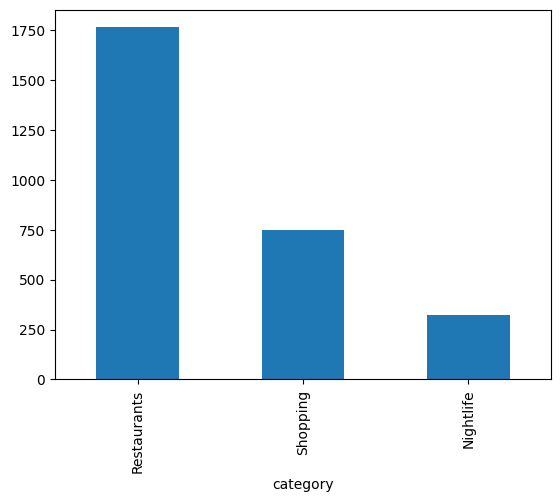

In [2]:
dataset['category'].value_counts().plot(kind='bar')

We can see that we an unbalanced dataset with category `Restaurants` dominating in occurence.

# Baseline Classifier
- Does not consider any other column than `review`.
- Uses the plain [CountVectorizor](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) preprocessing technique without any additional consideration, converting each review document into a count vector, where each point in position $i$ represents a count of a word $i$ wrt. to a dictionary that exhaustively defines the set of words found over all documents.

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

@dataclass
class Baseline(BaseEstimator, ClassifierMixin):
    _classifier = MultinomialNB()
    _vectorizer = CountVectorizer()
    
    def fit(self, features, labels):
        self._vectorizer.fit(features.loc[:,'review'])
        count_vectors = self._vectorizer.transform(features.loc[:, 'review'])
        
        return self._classifier.fit(count_vectors, labels)
    
    def predict(self, features):
        count_vectors = self._vectorizer.transform(features.loc[:, 'review'])
        
        return self._classifier.predict(count_vectors)
    
    def score(self, features, true_labels):
        predicted_labels = self.predict(features)
        
        return accuracy_score(true_labels, predicted_labels)

# Improved "Review Only" Classifier

Exposing the following tunable hyperparameters;
- N-Gram tokenisation of the reviews to use monograms, bigrams or a combination etc...
- Normalisation technique used on the word count vector
- Classifier, to either use the Multinomial or Complement classifiers
- Smoothing constant (aka alpha within context of the two classifers available to be used)
- Max features, the percentage of vocabulary to use (top X% percent of the desc ordered words by frequency)

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score
import pandas as pd

@dataclass
class Improved(BaseEstimator, ClassifierMixin):
    # "none", "tf", "tfidf"
    normalization: str = "none"
    # 2-tuple, as specified in the CountVectorizer ngram_range
    n_grams: tuple = (1, 1)
    # "multinomial", "complement"
    classifier: str = "multinomial"
    # smoothing variable within MultinomialNB and ComplementNB
    smoothing: float = 1.0
    # within the range [0, 1]; the proportion of max features
    max_features: float = 1.0

    _classifier = None
    _vectorizer = None
    _normalizer = None

    def _normalize_count_vectors(self, count_vectors):
        """_normalize_count_vectors uses the configured normalization technique
        to transform the word count vectors.
        """
        if self._normalizer is not None:
            return self._normalizer.transform(count_vectors)
        return count_vectors

    def _configure_vectorizer(self, reviews):
        """_configure_vectorizer builds a fitted vectorizer on the given
        reviews dependant on both hyperparameters n_grams and max_features.
        """
        global_vectorizer = CountVectorizer(ngram_range=self.n_grams)
        global_vectorizer.fit(reviews)
        number_words = len(global_vectorizer.vocabulary_)

        vectorizer = CountVectorizer(
            ngram_range=self.n_grams,
            max_features=int(number_words*self.max_features)
        )
        vectorizer.fit(reviews)
        return vectorizer

    def _configure_normalizer(self, count_vectors):
        """_configure_vectorizer builds a fitted vectorizer on the given
        reviews dependant on both hyperparameters n_grams and max_features.
        """
        if (self.normalization == "tf"):
            return TfidfTransformer(
                use_idf=False).fit(count_vectors)
        elif (self.normalization == "tfidf"):
            return TfidfTransformer(
                use_idf=True).fit(count_vectors)
        elif (self.normalization != "none"):
            raise Exception("Unknown normalisation technique")
        return None

    def _configure_classifier(self):
        if (self.classifier == "complement"):
            return ComplementNB(alpha=self.smoothing)
        elif (self.classifier == "multinomial"):
            return MultinomialNB(alpha=self.smoothing)
        else:
            raise Exception("Unknown classifier technique")

    def fit(self, features, labels):
        """ fit globally configures the classifier, vectorizer and
        normalizer onto the features and labels provided.
        """
        reviews = features.loc[:, 'review']

        self._vectorizer = self._configure_vectorizer(reviews)
        count_vectors = self._vectorizer.transform(reviews)

        self._normalizer = self._configure_normalizer(count_vectors)
        self._classifier = self._configure_classifier()

        return self._classifier.fit(
            self._normalize_count_vectors(count_vectors), labels)

    def predict(self, features):
        reviews = features.loc[:, 'review']

        count_vectors = self._vectorizer.transform(reviews)
        normalized_vectors = self._normalize_count_vectors(count_vectors)

        return self._classifier.predict(normalized_vectors)

    def score(self, features, true_labels):
        predicted_labels = self.predict(features)
        return accuracy_score(true_labels, predicted_labels)

    def get_params(self, deep=True):
        return {
            'normalization': self.normalization,
            'n_grams': self.n_grams,
            'classifier': self.classifier,
            'smoothing': self.smoothing,
            'max_features': self.max_features,
        }

    def set_params(self, normalization=None, n_grams=None, classifier=None,
                   smoothing=None, max_features=None):
        if normalization is not None:
            self.normalization = normalization

        if n_grams is not None:
            self.n_grams = n_grams

        if classifier is not None:
            self.classifier = classifier

        if smoothing is not None:
            self.smoothing = smoothing

        if max_features is not None:
            self.max_features = max_features

        return self

# Final Classifier
We find that using the `mean_checkin_time` has some level of polarisation wrt. categories given that we think can _add_ information of our improved baye's classifier. The issue is to discretize the continuous variable in a way that we can apply the same Naive Bayes' Classifiers.

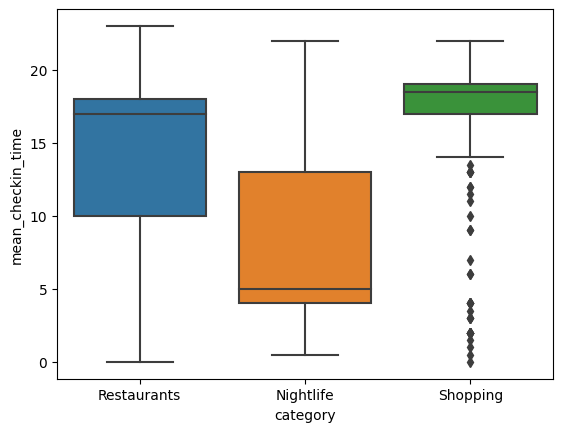

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='category', y='mean_checkin_time', data=dataset)
plt.show()

We let `Final` be a child class of the `Improved` class here, we overwrite methods `fit` and `predict` to suit the specific case of stitching together the additional column that is the `mean_check_in_time`. We scale the `mean_checkin_time` feature to be comparable to the rest

- Quantile Buckets, how many buckets to split `mean_checkin_time` into.

In [6]:
@dataclass
class Final(Improved):
    quantile_buckets: int = 5

    def fit(self, features, labels):
        """ fit globally configures the classifier, vectorizer and
        normalizer onto the features and labels provided.
        """
        reviews = features.loc[:, 'review']

        self._vectorizer = self._configure_vectorizer(reviews)
        count_vectors = self._vectorizer.transform(reviews)

        self._normalizer = self._configure_normalizer(count_vectors)
        self._classifier = self._configure_classifier()

        bucketed_checkin_times = pd.qcut(features['mean_checkin_time'],
                                         q=self.quantile_buckets, labels=False, duplicates='drop')
        bucketed_checkin_times_reshaped = np.array(bucketed_checkin_times).reshape(-1, 1)

        combined_features = np.hstack((
            self._normalize_count_vectors(count_vectors).toarray(),
            bucketed_checkin_times_reshaped)
        )

        return self._classifier.fit(combined_features, labels)

    def predict(self, features):
        reviews = features.loc[:, 'review']

        count_vectors = self._vectorizer.transform(reviews)
        bucketed_checkin_times = pd.qcut(features['mean_checkin_time'],
                                         q=self.quantile_buckets, labels=False, duplicates='drop')
        bucketed_checkin_times_reshaped = np.array(bucketed_checkin_times).reshape(-1, 1)

        combined_features = np.hstack((
            self._normalize_count_vectors(count_vectors).toarray(),
            bucketed_checkin_times_reshaped)
        )

        return self._classifier.predict(combined_features)
    
    def get_params(self, deep=True):
        params = super(Final, self).get_params(deep)
        params['quantile_buckets'] = self.quantile_buckets
        return params
    
    def set_params(self, normalization=None, n_grams=None, classifier=None,
                   smoothing=None, max_features=None, quantile_buckets=None):
        super(Final, self).set_params(normalization, n_grams, classifier, smoothing, max_features)
        if quantile_buckets is not None:
            self.quantile_buckets = quantile_buckets
        return self

# Hyperparameter Search

## Improved "Review Only"
We began to seriously run out of patience, hence commented out the n_grams hyperparameter because we consistently saw better results using monograms wrt. tokenisation and taking this hyper parameter out, halfs the total number of models to be built.

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'normalization': ["none", "tf", "tfidf"],
#     'n_grams': [(1,1), (2,2)],
    'classifier': ["multinomial", "complement"],
    'smoothing': [0.4, 0.45, 0.5, 0.55, 0.6],
    'max_features': [0.92,0.94,0.96],
}

tr_features, tr_labels = training.iloc[:, :-1], training.iloc[:, -1]

improved_search = GridSearchCV(
    estimator=Improved(),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
)

improved_search.fit(tr_features, tr_labels)
print(improved_search.best_params_)

def TunedImproved():
    return Improved(
        normalization=improved_search.best_params_['normalization'],
#         n_grams=improved_search.best_params_['n_grams'],
        classifier=improved_search.best_params_['classifier'],
        smoothing=improved_search.best_params_['smoothing'],
        max_features=improved_search.best_params_['max_features']
    )

{'classifier': 'multinomial', 'max_features': 0.96, 'normalization': 'none', 'smoothing': 0.4}


# Final

In [8]:
from sklearn.model_selection import GridSearchCV
import numpy as np


param_grid = {
    'normalization': ["none", "tf", "tfidf"],
#     'n_grams': [(1,1), (2,2)],
    'classifier': ["multinomial", "complement"],
    'smoothing': [0.5, 0.55, 0.6, 0.65],
    'max_features': [0.92,0.94,0.96],
    'quantile_buckets': [6, 7, 8, 9,10]
}

tr_features, tr_labels = training.iloc[:, :-1], training.iloc[:, -1]
clf = Final(quantile_buckets=7)
clf.fit(tr_features, tr_labels)
clf.get_params()

final_search = GridSearchCV(
    estimator=Final(),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
)

final_search.fit(tr_features, tr_labels)
print(final_search.best_params_)

def TunedFinal():
    return Final(
        normalization=final_search.best_params_['normalization'],
#         n_grams=final_search.best_params_['n_grams'],
        classifier=final_search.best_params_['classifier'],
        smoothing=final_search.best_params_['smoothing'],
        max_features=final_search.best_params_['max_features']
    )

/Users/floriansuess/.local/share/virtualenvs/ass2-fOAUB4Qj/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'classifier': 'multinomial', 'max_features': 0.92, 'normalization': 'none', 'quantile_buckets': 6, 'smoothing': 0.5}


# Evaluation

In [9]:
from sklearn.metrics import accuracy_score

classifiers = [
    ["baseline", Baseline()],
    ["improved", TunedImproved()],
    ["final", TunedFinal()],
]

tr_features, tr_labels = training.iloc[:, :-1], training.iloc[:, -1]
te_features, te_labels = testing.iloc[:, :-1], testing.iloc[:, -1]

for clf in classifiers:
    name, classifier = clf[0], clf[1]
    classifier.fit(tr_features, tr_labels)
    print(f"Accuracy of \"{name}\" classifier: %{classifier.score(te_features, te_labels)*100}")

Accuracy of "baseline" classifier: %82.74647887323944
Accuracy of "improved" classifier: %88.73239436619718
Accuracy of "final" classifier: %89.7887323943662


# Model Results Publish

In [10]:
final = TunedFinal()

features, labels = dataset.iloc[:, :-1], dataset.iloc[:, -1]
final.fit(features, labels)

testing = pd.read_csv('dataset/test.csv')
predicted_labels = final.predict(testing)

testing['category'] = predicted_labels

testing.loc[:, ['ID', 'category']].to_csv('dataset/predictions.csv', index=False)